In [39]:
# coding: utf-8

"""
CS579: Assignment 2

In this assignment, you will build a text classifier to determine whether a
movie review is expressing positive or negative sentiment. The data come from
the website IMDB.com.

You'll write code to preprocess the data in different ways (creating different
features), then compare the cross-validation accuracy of each approach. Then,
you'll compute accuracy on a test set and do some analysis of the errors.

The main method takes about 40 seconds for me to run on my laptop. Places to
check for inefficiency include the vectorize function and the
eval_all_combinations function.

Complete the 14 methods below, indicated by TODO.

As usual, completing one method at a time, and debugging with doctests, should
help.
"""

# No imports allowed besides these.
from collections import Counter, defaultdict
from itertools import chain, combinations
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from scipy.sparse import csr_matrix
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import string
import tarfile
import urllib.request
from nltk.corpus import stopwords

In [40]:
def download_data():
    """ Download and unzip data.
    DONE ALREADY.
    """
    url = 'https://www.dropbox.com/s/8oehplrobcgi9cq/imdb.tgz?dl=1'
    urllib.request.urlretrieve(url, 'imdb.tgz')
    tar = tarfile.open("imdb.tgz")
    tar.extractall()
    tar.close()

In [41]:
def read_data(path):
    """
    Walks all subdirectories of this path and reads all
    the text files and labels.
    DONE ALREADY.

    Params:
      path....path to files
    Returns:
      docs.....list of strings, one per document
      labels...list of ints, 1=positive, 0=negative label.
               Inferred from file path (i.e., if it contains
               'pos', it is 1, else 0)
    """
    fnames = sorted([f for f in glob.glob(os.path.join(path, 'pos', '*.txt'))])
    data = [(1, open(f).readlines()[0]) for f in sorted(fnames)]
    fnames = sorted([f for f in glob.glob(os.path.join(path, 'neg', '*.txt'))])
    data += [(0, open(f).readlines()[0]) for f in sorted(fnames)]
    data = sorted(data, key=lambda x: x[1])
    return np.array([d[1] for d in data]), np.array([d[0] for d in data])

In [42]:
def tokenize(doc, keep_internal_punct=False):
    """
    Tokenize a string.
    The string should be converted to lowercase.
    If keep_internal_punct is False, then return only the alphanumerics (letters, numbers and underscore).
    If keep_internal_punct is True, then also retain punctuation that
    is inside of a word. E.g., in the example below, the token "isn't"
    is maintained when keep_internal_punct=True; otherwise, it is
    split into "isn" and "t" tokens.

    Params:
      doc....a string.
      keep_internal_punct...see above
    Returns:
      a numpy array containing the resulting tokens.

    >>> tokenize(" Hi there! Isn't this fun?", keep_internal_punct=False)
    array(['hi', 'there', 'isn', 't', 'this', 'fun'], dtype='<U5')
    >>> tokenize("Hi there! Isn't this fun? ", keep_internal_punct=True)
    array(['hi', 'there', "isn't", 'this', 'fun'], dtype='<U5')
    """
    convert = doc.lower();
    if keep_internal_punct == False:
        return np.array(re.findall("[\w_]+", convert))
    else:
        return np.array(re.findall('[\w_][^\s]*[\w_]|[\w_]', convert))

In [43]:
def token_features(tokens, feats):
    """
    Add features for each token. The feature name
    is pre-pended with the string "token=".
    Note that the feats dict is modified in place,
    so there is no return value.

    Params:
      tokens...array of token strings from a document.
      feats....dict from feature name to frequency
    Returns:
      nothing; feats is modified in place.

    >>> feats = defaultdict(lambda: 0)
    >>> token_features(['hi', 'there', 'hi'], feats)
    >>> sorted(feats.items())
    [('token=hi', 2), ('token=there', 1)]
    """
    cnt = Counter(tokens)
    for i in cnt:
        feats["token="+i] = cnt[i]

In [44]:
def token_pair_features(tokens, feats, k=3):
    """
    Compute features indicating that two words occur near
    each other within a window of size k.

    For example [a, b, c, d] with k=3 will consider the
    windows: [a,b,c], [b,c,d]. In the first window,
    a_b, a_c, and b_c appear; in the second window,
    b_c, c_d, and b_d appear. This example is in the
    doctest below.
    Note that the order of the tokens in the feature name
    matches the order in which they appear in the document.
    (e.g., a__b, not b__a)

    Params:
      tokens....array of token strings from a document.
      feats.....a dict from feature to value
      k.........the window size (3 by default)
    Returns:
      nothing; feats is modified in place.

    >>> feats = defaultdict(lambda: 0)
    >>> token_pair_features(np.array(['a', 'b', 'c', 'd']), feats)
    >>> sorted(feats.items())
    [('token_pair=a__b', 1), ('token_pair=a__c', 1), ('token_pair=b__c', 2), ('token_pair=b__d', 1), ('token_pair=c__d', 1)]
    """
    windows = []
    def window_creator(list,degree):
        for ws in range(len(tokens) - degree + 1):
            yield [list[ws+l] for l in range(degree)]

    window_generator = window_creator(tokens,k)

    for window in window_generator:
        subseq = [c[0]+"__"+c[1] for c in combinations(window,2)]
        for sub in subseq:
            if "token_pair="+sub not in feats:
                feats["token_pair="+sub] = 1
            elif "token_pair="+sub in feats:
                feats["token_pair="+sub] = feats["token_pair="+sub] + 1

In [45]:
neg_words = set(['bad', 'hate', 'horrible', 'worst', 'boring'])
pos_words = set(['awesome', 'amazing', 'best', 'good', 'great', 'love', 'wonderful'])

def lexicon_features(tokens, feats):
    """
    Add features indicating how many time a token appears that matches either
    the neg_words or pos_words (defined above). The matching should ignore
    case.

    Params:
      tokens...array of token strings from a document.
      feats....dict from feature name to frequency
    Returns:
      nothing; feats is modified in place.

    In this example, 'LOVE' and 'great' match the pos_words,
    and 'boring' matches the neg_words list.
    >>> feats = defaultdict(lambda: 0)
    >>> lexicon_features(np.array(['i', 'LOVE', 'this', 'great', 'boring', 'movie']), feats)
    >>> sorted(feats.items())
    [('neg_words', 1), ('pos_words', 2)]
    """
    feats['pos_words'] = 0
    feats['neg_words'] = 0

    for token in tokens :
        if(token.lower() in pos_words):
            feats['pos_words'] += 1
        elif(token.lower() in neg_words):
            feats['neg_words'] += 1

In [46]:
def featurize(tokens, feature_fns):
    """
    Compute all features for a list of tokens from
    a single document.

    Params:
      tokens........array of token strings from a document.
      feature_fns...a list of functions, one per feature
    Returns:
      list of (feature, value) tuples, SORTED alphabetically
      by the feature name.

    >>> feats = featurize(np.array(['i', 'LOVE', 'this', 'great', 'movie']), [token_features, lexicon_features])
    >>> feats
    [('neg_words', 0), ('pos_words', 2), ('token=LOVE', 1), ('token=great', 1), ('token=i', 1), ('token=movie', 1), ('token=this', 1)]
    """
    feats = {}
    for features in feature_fns:
        features(tokens,feats)

    result = [(x, y) for x, y in feats.items()]

    return sorted(result,key=lambda x:x[0])

In [47]:
def vectorize(tokens_list, feature_fns, min_freq, vocab=None):
    """
    Given the tokens for a set of documents, create a sparse
    feature matrix, where each row represents a document, and
    each column represents a feature.

    Params:
      tokens_list...a list of lists; each sublist is an
                    array of token strings from a document.
      feature_fns...a list of functions, one per feature
      min_freq......Remove features that do not appear in
                    at least min_freq different documents.
    Returns:
      - a csr_matrix: See https://goo.gl/f5TiF1 for documentation.
      This is a sparse matrix (zero values are not stored).
      - vocab: a dict from feature name to column index. NOTE
      that the columns are sorted alphabetically (so, the feature
      "token=great" is column 0 and "token=horrible" is column 1
      because "great" < "horrible" alphabetically),

    When vocab is None, we build a new vocabulary from the given data.
    when vocab is not None, we do not build a new vocab, and we do not
    add any new terms to the vocabulary. This setting is to be used
    at test time.

    >>> docs = ["Isn't this movie great?", "Horrible, horrible movie"]
    >>> tokens_list = [tokenize(d) for d in docs]
    >>> feature_fns = [token_features]
    >>> X, vocab = vectorize(tokens_list, feature_fns, min_freq=1)
    >>> type(X)
    <class 'scipy.sparse.csr.csr_matrix'>
    >>> X.toarray()
    array([[1, 0, 1, 1, 1, 1],
           [0, 2, 0, 1, 0, 0]], dtype=int64)
    >>> sorted(vocab.items(), key=lambda x: x[1])
    [('token=great', 0), ('token=horrible', 1), ('token=isn', 2), ('token=movie', 3), ('token=t', 4), ('token=this', 5)]
    """
    feats_list = list(defaultdict(lambda: 0))
    feats_freq = defaultdict(lambda: 0)

    row = []
    col = []
    data = []
    
    for token in tokens_list:
        feats_list.append(featurize(token, feature_fns))
    if vocab == None:
        for feats in feats_list:
            for x, v in feats:
                if v != 0:
                    feats_freq[x] += 1
        id = 0
        vocab = dict()
        for f, v in sorted(feats_freq.items()):
            if v >= min_freq:
                vocab[f] = id
                id += 1
    for i in range(0, len(feats_list)):
        for fkey, v in feats_list[i]:
            if fkey in vocab:
                row.append(i)
                col.append(vocab[fkey])
                data.append(v)
                
    return csr_matrix((data, (row, col)), shape=(len(feats_list), len(vocab)),dtype=np.int64), vocab

In [48]:
def accuracy_score(truth, predicted):
    """ Compute accuracy of predictions.
    DONE ALREADY
    Params:
      truth.......array of true labels (0 or 1)
      predicted...array of predicted labels (0 or 1)
    """
    return len(np.where(truth==predicted)[0]) / len(truth)

In [49]:
def cross_validation_accuracy(clf, X, labels, k):
    """
    Compute the average testing accuracy over k folds of cross-validation. You
    can use sklearn's KFold class here (no random seed, and no shuffling
    needed).

    Params:
      clf......A LogisticRegression classifier.
      X........A csr_matrix of features.
      labels...The true labels for each instance in X
      k........The number of cross-validation folds.

    Returns:
      The average testing accuracy of the classifier
      over each fold of cross-validation.
    """
    cv_kf = KFold(k, False)
    accuracies = []
    
    for train_ind, test_ind in cv_kf.split(X):
        X_train, X_test = X[train_ind], X[test_ind]
        labels_train, labels_test = labels[train_ind], labels[test_ind]
        clf.fit(X_train, labels_train)
        pred_labels = clf.predict(X_test)
        acc_score = accuracy_score(labels_test, pred_labels)
        accuracies.append(acc_score)

    average = np.mean(np.array(accuracies))

    return average

In [50]:
def eval_all_combinations(docs, labels, punct_vals,
                          feature_fns, min_freqs):
    """
    Enumerate all possible classifier settings and compute the
    cross validation accuracy for each setting. We will use this
    to determine which setting has the best accuracy.

    For each setting, construct a LogisticRegression classifier
    and compute its cross-validation accuracy for that setting.

    In addition to looping over possible assignments to
    keep_internal_punct and min_freqs, we will enumerate all
    possible combinations of feature functions. So, if
    feature_fns = [token_features, token_pair_features, lexicon_features],
    then we will consider all 7 combinations of features (see Log.txt
    for more examples).

    Params:
      docs..........The list of original training documents.
      labels........The true labels for each training document (0 or 1)
      punct_vals....List of possible assignments to
                    keep_internal_punct (e.g., [True, False])
      feature_fns...List of possible feature functions to use
      min_freqs.....List of possible min_freq values to use
                    (e.g., [2,5,10])

    Returns:
      A list of dicts, one per combination. Each dict has
      four keys:
      'punct': True or False, the setting of keep_internal_punct
      'features': The list of functions used to compute features.
      'min_freq': The setting of the min_freq parameter.
      'accuracy': The average cross_validation accuracy for this setting, using 5 folds.

      This list should be SORTED in descending order of accuracy.

      This function will take a bit longer to run (~20s for me).
    """
    results = []
    feature_fns_enum = []
    
    for i in range(1, len(feature_fns) + 1):
        for feature_comb in combinations(feature_fns, i):
            feature_fns_enum.append([*feature_comb])

    for punct in punct_vals:
        tokens_list = [tokenize(doc, punct) for doc in docs]
        for functns in feature_fns_enum:
            for min_freq in min_freqs:
                X, vocab = vectorize(tokens_list, functns, min_freq)
                accuracy = cross_validation_accuracy(LogisticRegression(), X, labels, 5)
                results.append({'features': functns, 'punct': punct, 'accuracy': accuracy, 'min_freq': min_freq})

    return sorted(results, key = lambda x: (-x['accuracy'], -x['min_freq']))

In [51]:
def plot_sorted_accuracies(results):
    """
    Plot all accuracies from the result of eval_all_combinations
    in ascending order of accuracy.
    Save to "accuracies.png".
    """
    accuracyList=[]
    for result in results:
        accuracyList.append(result['accuracy'])
    accuracyList=sorted(accuracyList)
    plt.plot(range(42), accuracyList)
    plt.xlabel('setting')
    plt.ylabel('accuracy')
    plt.savefig('accuracies.png')

In [52]:
def mean_accuracy_per_setting(results):
    """
    To determine how important each model setting is to overall accuracy,
    we'll compute the mean accuracy of all combinations with a particular
    setting. For example, compute the mean accuracy of all runs with
    min_freq=2.

    Params:
      results...The output of eval_all_combinations
    Returns:
      A list of (accuracy, setting) tuples, SORTED in
      descending order of accuracy.
    """
    setaccuracies = defaultdict(lambda: 0.)
    setfreq = defaultdict(lambda: 0)
    for r in results:
        setaccuracies['punct' + '=' + str(r['punct'])] += r['accuracy']
        setfreq['punct' + '=' + str(r['punct'])] += 1
        fnname = "features="
        for fn in r['features']:
            fnname += " " + fn.__name__
        setaccuracies[fnname] += r['accuracy']
        setfreq[fnname] += 1
        setaccuracies['min_freq' + '=' + str(r['min_freq'])] += r['accuracy']
        setfreq['min_freq' + '=' + str(r['min_freq'])] += 1

    for key in setaccuracies:
        setaccuracies[key] /= setfreq[key]

    return[(v, k) for k, v in sorted(setaccuracies.items(), key = lambda x: -x[1])]

In [53]:
def fit_best_classifier(docs, labels, best_result):
    """
    Using the best setting from eval_all_combinations,
    re-vectorize all the training data and fit a
    LogisticRegression classifier to all training data.
    (i.e., no cross-validation done here)

    Params:
      docs..........List of training document strings.
      labels........The true labels for each training document (0 or 1)
      best_result...Element of eval_all_combinations
                    with highest accuracy
    Returns:
      clf.....A LogisticRegression classifier fit to all
            training data.
      vocab...The dict from feature name to column index.
    """
    tokens = []
    
    for i in docs:
        tokens.append(tokenize(i, best_result['punct']))
    
    X, vocab = vectorize(tokens, best_result['features'], best_result['min_freq'])
    clf = LogisticRegression()
    clf.fit(X, labels)
    
    return clf,vocab

In [54]:
def top_coefs(clf, label, n, vocab):
    """
    Find the n features with the highest coefficients in
    this classifier for this label.
    See the .coef_ attribute of LogisticRegression.

    Params:
      clf.....LogisticRegression classifier
      label...1 or 0; if 1, return the top coefficients
              for the positive class; else for negative.
      n.......The number of coefficients to return.
      vocab...Dict from feature name to column index.
    Returns:
      List of (feature_name, coefficient) tuples, SORTED
      in descending order of the coefficient for the
      given class label.
    """
    output = []

    if label == 1:
        for feat in vocab:
            output.append((feat,clf.coef_[0][vocab[feat]]))
        return sorted(output,key=lambda x:-x[1])[:n]

    elif label == 0:
        for feat in vocab:
            output.append((feat, clf.coef_[0][vocab[feat]]))
        sort = sorted(output, key=lambda x: x[1])
        l = []
        for i in sort[:n]:
            l.append((i[0], -1 * i[1]))

        return l

In [55]:
def parse_test_data(best_result, vocab):
    """
    Using the vocabulary fit to the training data, read
    and vectorize the testing data. Note that vocab should
    be passed to the vectorize function to ensure the feature
    mapping is consistent from training to testing.

    Note: use read_data function defined above to read the
    test data.

    Params:
      best_result...Element of eval_all_combinations
                    with highest accuracy
      vocab.........dict from feature name to column index,
                    built from the training data.
    Returns:
      test_docs.....List of strings, one per testing document,
                    containing the raw.
      test_labels...List of ints, one per testing document,
                    1 for positive, 0 for negative.
      X_test........A csr_matrix representing the features
                    in the test data. Each row is a document,
                    each column is a feature.
    """
    l = []
    docs, labels = read_data(os.path.join('data', 'test'))
    
    for i in docs:
        l.append(tokenize(i, best_result['punct']))
        
    X_test, vocab = vectorize(l, best_result['features'], best_result['min_freq'], vocab)
    
    return docs, labels, X_test

In [56]:
def print_top_misclassified(test_docs, test_labels, X_test, clf, n):
    """
    Print the n testing documents that are misclassified by the
    largest margin. By using the .predict_proba function of
    LogisticRegression <https://goo.gl/4WXbYA>, we can get the
    predicted probabilities of each class for each instance.
    We will first identify all incorrectly classified documents,
    then sort them in descending order of the predicted probability
    for the incorrect class.
    E.g., if document i is misclassified as positive, we will
    consider the probability of the positive class when sorting.

    Params:
      test_docs.....List of strings, one per test document
      test_labels...Array of true testing labels
      X_test........csr_matrix for test data
      clf...........LogisticRegression classifier fit on all training
                    data.
      n.............The number of documents to print.

    Returns:
      Nothing; see Log.txt for example printed output.
    """
    predict = clf.predict(X_test)
    different = np.where(predict != test_labels)[0]  

    predict_prob = clf.predict_proba(X_test)
    wrong_pred = predict_prob[different]

    keys = np.argsort(np.amax(wrong_pred, axis = 1))[::-1][:n] 
    
    for i in range(0, n):
        doc_keys = different[keys[i]]
        truth=str(test_labels[doc_keys])
        predicted=str(predict[doc_keys])
        probab=str(np.max(predict_prob[doc_keys]))
        print('truth='+truth+' predicted='+predicted+' proba='+probab)
        print(test_docs[doc_keys]+'\n')

best cross-validation result:
{'features': [<function token_pair_features at 0x000002144A02AF28>, <function lexicon_features at 0x000002144A02A0D0>], 'punct': True, 'accuracy': 0.7700000000000001, 'min_freq': 2}
worst cross-validation result:
{'features': [<function lexicon_features at 0x000002144A02A0D0>], 'punct': True, 'accuracy': 0.6475, 'min_freq': 2}

Mean Accuracies per Setting:
features= token_pair_features lexicon_features: 0.75000
features= token_features token_pair_features lexicon_features: 0.74542
features= token_features token_pair_features: 0.73583
features= token_pair_features: 0.72917
min_freq=2: 0.72321
punct=False: 0.72012
min_freq=5: 0.71857
punct=True: 0.70845
min_freq=10: 0.70107
features= token_features lexicon_features: 0.69833
features= token_features: 0.69000
features= lexicon_features: 0.65125

TOP COEFFICIENTS PER CLASS:
negative words:
neg_words: 0.66102
token_pair=the__worst: 0.37471
token_pair=is__so: 0.31476
token_pair=about__the: 0.30262
token_pair=like

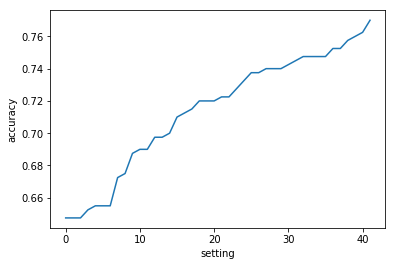

In [57]:
def main():
    """
    Put it all together.
    ALREADY DONE.
    """
    feature_fns = [token_features, token_pair_features, lexicon_features]
    # Download and read data.
    download_data()
    docs, labels = read_data(os.path.join('data', 'train'))
    # Evaluate accuracy of many combinations
    # of tokenization/featurization.
    results = eval_all_combinations(docs, labels,
                                    [True, False],
                                    feature_fns,
                                    [2,5,10])
    # Print information about these results.
    best_result = results[0]
    worst_result = results[-1]
    print('best cross-validation result:\n%s' % str(best_result))
    print('worst cross-validation result:\n%s' % str(worst_result))
    plot_sorted_accuracies(results)
    print('\nMean Accuracies per Setting:')
    print('\n'.join(['%s: %.5f' % (s,v) for v,s in mean_accuracy_per_setting(results)]))

    # Fit best classifier.
    clf, vocab = fit_best_classifier(docs, labels, results[0])

    # Print top coefficients per class.
    print('\nTOP COEFFICIENTS PER CLASS:')
    print('negative words:')
    print('\n'.join(['%s: %.5f' % (t,v) for t,v in top_coefs(clf, 0, 5, vocab)]))
    print('\npositive words:')
    print('\n'.join(['%s: %.5f' % (t,v) for t,v in top_coefs(clf, 1, 5, vocab)]))

    # Parse test data
    test_docs, test_labels, X_test = parse_test_data(best_result, vocab)

    # Evaluate on test set.
    predictions = clf.predict(X_test)
    print('testing accuracy=%f' %
          accuracy_score(test_labels, predictions))

    print('\nTOP MISCLASSIFIED TEST DOCUMENTS:')
    print_top_misclassified(test_docs, test_labels, X_test, clf, 5)


if __name__ == '__main__':
    main()